# Extracting visual features from the TotallyLooksLike Dataset

In [534]:
%pylab inline
from scipy.spatial.distance import cdist
# basic function for reading an image pair and splitting to left and right halves
# and other utility functions
def readAndSplit(p):
    I = imread(p)
    I = I[:245,:400,:3]
    s = hsplit(I,2)
    return s[0],s[1]
  
# now we extract features from all left and right images.


import errno    
import os
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

# Let's make a bunch of models.

toSaveFigures = False
saveFigsBaseDir = 'figures'

Populating the interactive namespace from numpy and matplotlib


# Feature Extraction
## Generic Features

In [535]:

import pickle

import torch,os
from glob import glob
import torch.nn as nn
from torchvision import models
from torchvision import transforms
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Scale(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])
networks = dict(resnet18 = models.resnet18,
                resnet50 = models.resnet50,
                resnet152 = models.resnet152,
                densenet121 = models.densenet121,
                densenet169 = models.densenet169,
                densenet201 = models.densenet201,
                alexnet = models.alexnet,
                vgg16=models.vgg16)
class VGG_features(nn.Module):
    def __init__(self, vgg_net):
        super(VGG_features, self).__init__()
        self.vgg_net = vgg_net
        self.C = nn.Sequential(*list(vgg_net.classifier.children())[:-2])
    def forward(self, x):
        x = self.vgg_net.features(x)
        x = x.view(x.size(0), -1)
        x = self.C(x)
        return x
def getNetwork(networkName):   
    model = networks[networkName](pretrained=True)
    if 'resnet' in networkName:        
        model = nn.Sequential(*list(model.children())[:-1])
    elif 'densenet' in networkName:
        return nn.Sequential(model.features,nn.AvgPool2d(7,stride=1))
    else:
        assert 'vgg' in networkName or 'alexnet' in networkName
        return VGG_features(model)
    return model
homedir=os.path.expanduser('~')
baseDir = os.path.join(homedir,'TotallyLooksLike')
imageDir=os.path.join(baseDir,'Images')
outputDir=os.path.join(baseDir,'results')

imageNames = []
import PIL
from PIL import Image
from torch.autograd import Variable
import os
import cPickle as pickle
from tqdm import tqdm
print 'extracting features using all networks...'
G = sorted(glob(os.path.join(imageDir,'*.jpg'))) # get all images names, sorted 
for networkName,networkFun in networks.items():
    curOutPath = os.path.join(outputDir,networkName+'.pkl')
    print 'checking for',curOutPath,'...'
    if os.path.isfile(curOutPath):
        print 'exists! - skipping'
        continue
    m = getNetwork(networkName)    
    m.eval()
    print 'networkName',networkName    
    m.cuda();
    leftResults = []
    rightResults = []
    for imgPath in tqdm(G):
        #resPath = imgPath.replace('.jpg','.pkl')
        #if os.path.isfile(resPath):
        #    continue
        #print imgPath
        I = imread(imgPath)[:,:,:3]
        I = I[:245,:400,:]
        s = hsplit(I,2)
        curImage = s[0]
        leftResult = m(Variable(preprocess(Image.fromarray(curImage)).unsqueeze(0).cuda())).squeeze().data.cpu().numpy()
        curImage = s[1]
        rightResult = m(Variable(preprocess(Image.fromarray(curImage)).unsqueeze(0).cuda())).squeeze().data.cpu().numpy()
        
        leftResults.append(leftResult)
        rightResults.append(rightResult)
        
    pickle.dump(dict(leftResults=leftResults,rightResults=rightResults,G=G),open(curOutPath,'wb'))        
    #pickle.dump(d
print 'DONE'

extracting features using all networks...
checking for /home/amir/TotallyLooksLike/results/resnet18.pkl ...
exists! - skipping
checking for /home/amir/TotallyLooksLike/results/resnet50.pkl ...
exists! - skipping
checking for /home/amir/TotallyLooksLike/results/vgg16.pkl ...
exists! - skipping
checking for /home/amir/TotallyLooksLike/results/densenet201.pkl ...
exists! - skipping
checking for /home/amir/TotallyLooksLike/results/densenet121.pkl ...
exists! - skipping
checking for /home/amir/TotallyLooksLike/results/resnet152.pkl ...
exists! - skipping
checking for /home/amir/TotallyLooksLike/results/densenet169.pkl ...
exists! - skipping
checking for /home/amir/TotallyLooksLike/results/alexnet.pkl ...
exists! - skipping
DONE


## Generic Face Features

In [11]:
m = getNetwork('densenet121')
m.eval()
m.cuda()
faces_generic_feats = {}
curOutPath = os.path.join(outputDir,'faces_generic_feats.pkl')
if os.path.isfile(curOutPath):
    print 'generic face features exist - skipping.' 
    faces_generic_feats = pickle.load(open(curOutPath,'rb'))    
else:
    for k,v in tqdm(a.items()):
        left_feats = []
        right_feats = []
        for img in v['left_face_imgs']:
            res = m(Variable(preprocess(Image.fromarray(img)).unsqueeze(0).cuda())).squeeze().data.cpu().numpy()
            left_feats.append(res)
        for img in v['right_face_imgs']:
            res = m(Variable(preprocess(Image.fromarray(img)).unsqueeze(0).cuda())).squeeze().data.cpu().numpy()
            right_feats.append(res)
        faces_generic_feats[k]=dict(left_feats=left_feats,right_feats=right_feats)    
    print('dumping')
    pickle.dump(faces_generic_feats,open(curOutPath,'wb'),protocol=2)

generic face features exist - skipping.


# Analysis

## Face detection stats.

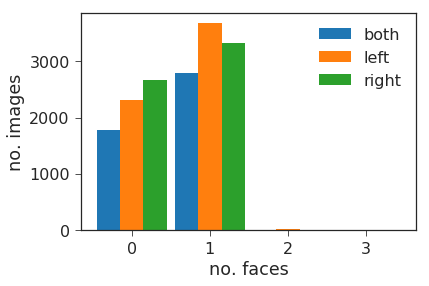

In [537]:
# let's show both the correlation between the number of left, right faces, as well as the distribution of faces overall.
face_enc_path = os.path.join(outputDir,'face_encodings.pkl')
a = pickle.load(open(face_enc_path,'rb'))
import seaborn as sns
n_faces_left = zeros(len(a))
n_faces_right = zeros(len(a))
for i,aa in enumerate(a.values()):
    n_faces_left[i]=len(aa['left_enc'])
    n_faces_right[i]=len(aa['right_enc'])
    
# plot for each condition the number of total faces and the agreement
r = []
r_left = []
r_right = []
R=4
for cc in range(R):
    c=n_faces_left==cc
    r.append(sum(logical_and(n_faces_left==cc,n_faces_right==cc)))
    r_left.append(sum(n_faces_left==cc))
    r_right.append(sum(n_faces_right==cc))
    #r.append(sum(n_faces_left[c]==n_faces_right[c])/float(sum(c)))
    #r_left = len(n_faces_left[c])
ax = plt.subplot(111)
w = 0.3
x=array(range(R)).astype(float)
ax.bar(x-w, r,width=w,label='both')#,color='b',align='center')
ax.bar(x, r_left,width=w,label='left')#,color='g',align='center')
ax.bar(x+w, r_right,width=w,label='right')#,color='r',align='center')
legend()
xlabel('no. faces')
ylabel('no. images')

if toSaveFigures:
  savefig(os.path.join(saveFigsBaseDir,'face_counts.pdf'),bbox_inches='tight')
#bar(height=[r,r_left,r_right])

# Compute all pairwise distances
## Left-to-RightDistances

In [13]:
# ok, now let's compute the pairwise distances between all left/right images.
for networkName,networkFun in networks.items():
    curOutPath = os.path.join(outputDir,networkName+'.pkl')
    dists_out_path = curOutPath+'.dist'    
    if os.path.isfile(dists_out_path):
        print dists_out_path,'exist - skipping'
        continue
    else:
        print 'calculating distances....',
        a = pickle.load(open(curOutPath))
        L = stack(a['leftResults'])
        R = stack(a['rightResults'])
        D = cdist(L,R)
        D1 = cdist(L,R,metric='cosine')
        pickle.dump(dict(D_euclid=D.astype(float32),D_cosine=D1.astype(float32),G=G),open(dists_out_path,'wb'),protocol=2)
        print('done!')
        
# calculate the inner distance to decide which pairs to discard

/home/amir/TotallyLooksLike/results/resnet18.pkl.dist exist - skipping
/home/amir/TotallyLooksLike/results/resnet50.pkl.dist exist - skipping
/home/amir/TotallyLooksLike/results/vgg16.pkl.dist exist - skipping
/home/amir/TotallyLooksLike/results/densenet201.pkl.dist exist - skipping
/home/amir/TotallyLooksLike/results/densenet121.pkl.dist exist - skipping
/home/amir/TotallyLooksLike/results/resnet152.pkl.dist exist - skipping
/home/amir/TotallyLooksLike/results/densenet169.pkl.dist exist - skipping
/home/amir/TotallyLooksLike/results/alexnet.pkl.dist exist - skipping


## Internal distances
### Generic Features

In [14]:
curOutPath=os.path.join(outputDir,'densenet121.pkl')
generic_inner_path = os.path.join(outputDir,'generic_inner_distances.pkl')
if os.path.isfile(generic_inner_path):
    print('generic features',generic_inner_path,'exists - skipping')
    generic_inner_dists_sorted = pickle.load(open(generic_inner_path))
else:
    a = pickle.load(open(curOutPath))
    L = stack(a['leftResults'])
    R = stack(a['rightResults'])
    print 'computing inner left distances'
    D1_LL = cdist(L,L,metric='cosine').astype(float32)
    print 'computing inner right distances'
    D1_RR = cdist(R,R,metric='cosine').astype(float32)
    #L_sorted = D1_LL.argsort(1).astype(int16)
    #R_sorted = D1_RR.argsort(1).astype(int16)
    generic_inner_dists_sorted = dict(D1_LL=D1_LL, D1_RR=D1_RR)
    print('dumping...')
    #pickle.dump(generic_inner_dists_sorted, open(generic_inner_path,'wb'), protocol=2)
    

('generic features', '/home/amir/TotallyLooksLike/results/generic_inner_distances.pkl', 'exists - skipping')


### Face features

In [15]:
# left-left faces and right-right faces.
side1 = 'left_enc'
side2 = 'right_enc'
for cur_side in [side1,side2]:
    for is_generic in [False,True]:
        print cur_side
        G = sorted(glob(os.path.join(imageDir,'*.jpg')))
        if is_generic:
            face_dists_path_inner = os.path.join(outputDir,'faces_generic_dists_inner_{}.pkl'.format(cur_side)) 
            chosen_metric = 'cosine'
        else:
            face_dists_path_inner = os.path.join(outputDir,'faces_dists_inner_{}.pkl'.format(cur_side)) 
            chosen_metric='euclidean'
        if os.path.isfile(face_dists_path_inner):
            print 'file already exists - loading pre-computed...',
            face_dists = pickle.load(open(face_dists_path_inner,'rb'))
            print 'done'
        else:
            if is_generic:
                print 'loading generic feats....'
                face_enc_path = os.path.join(outputDir,'faces_generic_feats.pkl')
                cur_side = 'left_feats' if cur_side==side1 else 'right_feats' # small fix because of inconsistent naming.
            else:
                face_enc_path = os.path.join(outputDir,'face_encodings.pkl')
            a = pickle.load(open(face_enc_path,'rb'))
            sorted_files = [g.split('/')[-1] for g in G]
            n_images = len(sorted_files)
            print n_images
            face_dists_inner = 10**9*np.ones((n_images,n_images),dtype=float32)
            dd = {}
            for i,s_i in enumerate(sorted_files):
                if i % 100 == 0:
                    print
                left_feats = a[s_i][cur_side]
                if len(left_feats) == 0:
                    print '-',
                    continue
                print '*',
                left_feats=stack(left_feats)
                for j,s_j in enumerate(sorted_files):
                    left_feats1 = a[s_j][cur_side]
                    if len(left_feats1) == 0:
                        continue
                    left_feats1=stack(left_feats1)                
                    face_dists_inner[i,j] = min(face_dists_inner[i,j], cdist(left_feats,left_feats1,metric=chosen_metric).ravel().min())
            dd[cur_side] = face_dists_inner.astype(float32)
            print('dumping...')
            pickle.dump(dd,open(face_dists_path_inner,'wb'),protocol=2)

left_enc
file already exists - loading pre-computed... done
left_enc
file already exists - loading pre-computed... done
right_enc
file already exists - loading pre-computed... done
right_enc
file already exists - loading pre-computed... done


# Analyze internal distances to detect duplicates.

In [16]:
def makeDupsGallery(dists,mins,thresh=.15,suff='',sides=[0,0]):
    G = sorted(glob(os.path.join(imageDir,'*.jpg')))
    outDir = '/media/amir/newhd/TotallyLooksLike/sorted_for_dups_{}/'.format(suff)
    if not os.path.isdir(outDir):
        os.mkdir(outDir)
    for k in range(len(dists)):
        if k % 100 == 0:
            print '.',k,
        d = dists[k]
        dd = mins[k]
        cur_dist = d
        if cur_dist > thresh:
            continue
        z=[ readAndSplit(G[k])[sides[0]]    ,readAndSplit(G[dd])[sides[1]]]
        imsave('{}/{:02.10f}_{}.jpg'.format(outDir,d,str(k).zfill(5)),hstack(z),format='jpg')
        if k > 1000:
            break
    #4242
#right_dists_second = D1_RR[:,1]

In [538]:

from copy import deepcopy
generic_dup_threshold = .15
face_dup_threshold = .4
a = pickle.load(open(generic_inner_path))
#L_sorted = D1_LL.argsort(1).astype(int16)
#R_sorted = D1_RR.argsort(1).astype(int16)
D1_LL = deepcopy(a['D1_LL'])
D1_LL = D1_LL+eye(len(D1_RR))*100;
mins  = D1_LL.argmin(1)
dists = D1_LL.min(1)
dists_left = D1_LL.min(1)


D1_RR = deepcopy(a['D1_RR'])
D1_RR = D1_RR+eye(len(D1_RR))*100;
mins  = D1_RR.argmin(1)
dists_right = D1_RR.min(1)
#makeDupsGallery(dists_right,mins,10,'generic_RR')
#makeDupsGallery(dists,mins,10,'generic_LL',[0,0])

In [539]:
# Now, let us look at cross-duplicates.
networkName='densenet121'       
curOutPath = os.path.join(outputDir,networkName+'.pkl')
dists_out_path = curOutPath+'.dist'
print 'loading...'
a = pickle.load(open(dists_out_path))
a1 = deepcopy(a['D_cosine'])
a1 = a1 +100*eye(size(a1[0]))
cross_dists = a1.min(1)
cross_mins = a1.argmin(1)

loading...


In [621]:
right_generic_thresh=.1
is_dup_right = dists_right <=right_generic_thresh
is_dup_left = dists_left <=right_generic_thresh


In [542]:
face_dists_path_inner_left = os.path.join(outputDir,'faces_dists_inner_{}.pkl'.format(side1)) 
face_dists = pickle.load(open(face_dists_path_inner_left,'rb'))
D1_LL = deepcopy(face_dists[side1])
D1_LL.sort(1);
face_dists_path_inner_right = os.path.join(outputDir,'faces_dists_inner_{}.pkl'.format(side2));
face_dists = pickle.load(open(face_dists_path_inner_right,'rb'))
D1_RR = deepcopy(face_dists[side2])
D1_RR.sort(1);
left_dists_second=D1_LL[:,1]
right_dists_second=D1_RR[:,1]
face_dups_left = (left_dists_second<=.4)
face_dups_right = (right_dists_second<=.4)
face_feature_dups=dict(face_dups_left=face_dups_left,face_dups_right=face_dups_right,left_dists_second=left_dists_second,right_dists_second=right_dists_second)

# and do the same for the face dists....

# do it with faces.
face_dists_path = os.path.join(outputDir,'faces_dists.pkl') 
if os.path.isfile(face_dists_path):
    face_dists = pickle.load(open(face_dists_path,'rb'))
a = pickle.load(open(face_enc_path,'rb'))
G=[]
for z in a.keys():
    G.append(os.path.join('/media/amir/newhd/TotallyLooksLike/Images/',z))

a_face_dist = pickle.load(open(face_dists_path));
a_face_dist = a_face_dist +100*eye(len(a_face_dist))
cross_face_dists = a_face_dist.min(1)
cross_face_mins = a_face_dist.argmin(1)

In [543]:
####### Now, generic features.
#cur_side = 'left_feats' if cur_side==side1 else 'right_feats'
face_dists_path_inner_left = os.path.join(outputDir,'faces_generic_dists_inner_{}.pkl'.format(side1));
face_dists = pickle.load(open(face_dists_path_inner_left,'rb'))
D1_LL = deepcopy(face_dists['left_feats'])
D1_LL.sort(1);
face_dists_path_inner_right = os.path.join(outputDir,'faces_generic_dists_inner_{}.pkl'.format(side2));
face_dists = pickle.load(open(face_dists_path_inner_right,'rb'))
D1_RR = deepcopy(face_dists['right_feats'])
D1_RR.sort(1);
left_dists_second=D1_LL[:,1]
right_dists_second=D1_RR[:,1]

In [544]:
face_dups_left = (left_dists_second<=.15)
face_dups_right = (right_dists_second<=.15)
face_generic_feature_dups=dict(face_dups_left=face_dups_left,face_dups_right=face_dups_right,left_dists_second=left_dists_second,right_dists_second=right_dists_second)

In [547]:
face_dists_path_inner_left = os.path.join(outputDir,'faces_dists_inner_{}.pkl'.format(side1)) 
face_dists = pickle.load(open(face_dists_path_inner_left,'rb'))
D1_LL = deepcopy(face_dists[side1])

In [548]:
face_dists_path_inner_left = os.path.join(outputDir,'faces_dists_inner_left_enc.pkl');
face_dists = pickle.load(open(face_dists_path_inner_left,'rb'))
D1_LL = deepcopy(face_dists['left_enc'])
D1_LL = D1_LL+eye(len(D1_LL))*100;
mins_face_left  = D1_LL.argmin(1)
dists_face_left = D1_LL.min(1)

In [26]:
#makeDupsGallery(dists_face_left,mins_face_left,1.5,'faces_LL',[0,0])

IOError: [Errno 2] No such file or directory: '/media/amir/newhd/TotallyLooksLike/results/faces_dists_inner_left_enc.pkl'

In [549]:
face_dists_path_inner_right = os.path.join(outputDir,'faces_dists_inner_right_enc.pkl');
face_dists = pickle.load(open(face_dists_path_inner_right,'rb'))
D1_RR = deepcopy(face_dists['right_enc'])
D1_RR = D1_RR+eye(len(D1_LL))*100;
mins_face_right  = D1_RR.argmin(1)
dists_face_right = D1_RR.min(1)

In [550]:
# 0.05
face_thresh = 0.05

In [551]:
face_dists_path_inner_right = os.path.join(outputDir,'faces_dists_inner_right_enc.pkl');
face_dists = pickle.load(open(face_dists_path_inner_right,'rb'))

In [552]:
D1_RR = deepcopy(face_dists['right_enc'])
D1_RR = D1_RR+eye(len(D1_RR))*100;

In [553]:
mins_face  = D1_RR.argmin(1)
dists_face = D1_RR.min(1)

In [555]:
face_dups = logical_or(mins_face_left <=.4,mins_face_right<=.4)

In [556]:
face_dups.sum()

3206

In [561]:
all_dups_path = os.path.join(baseDir,'results/dup.pkl')
if not os.path.isfile(all_dups_path):
    dup_dict = dict(is_dup_right=is_dup_right,face_dups=face_dups)
    
    pickle.dump(dup_dict,open(all_dups_path,'wb'),protocol=2)
else:
    dup_dict = pickle.load(open(all_dups_path))

In [562]:
#L = stack(a['rightResults'])
curOutPath=os.path.join(baseDir,'results/densenet121.pkl')
a = pickle.load(open(curOutPath))
L = stack(a['leftResults'])

In [ ]:
# Do this for faces, too : find sets of duplicate faces....

In [563]:
face_enc_path = os.path.join(outputDir,'face_encodings.pkl')
#/media/amir/newhd/TotallyLooksLike/results/face_encodings.pkl_2
a_face = pickle.load(open(face_enc_path,'rb'))
has_face = {}
for k,v in a_face.items():
    has_face[k] = max(len(v['left_enc']),len(v['right_enc'])) 
new_sel=[]
for k in a['G']:
    new_sel.append(has_face[k.split('/')[-1]]==1)
sel_face=array(new_sel)

# ok, now calculate distances for each pair of images for each pair of faces within, skipping images with no faces (set their face distance to INF). Note this is done only for the L2 distance

In [564]:
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)

In [565]:
networkName = 'densenet121'
curOutPath = os.path.join(outputDir,networkName+'.pkl')
dists_out_path = curOutPath+'.dist'
a = pickle.load(open(dists_out_path))

In [566]:
import pandas as pd
df = pd.read_csv(os.path.join(baseDir,'Votes/test2.csv'))
#df.sort_values('id').wins

# Test any correlation between cosine distance and upvotes on website

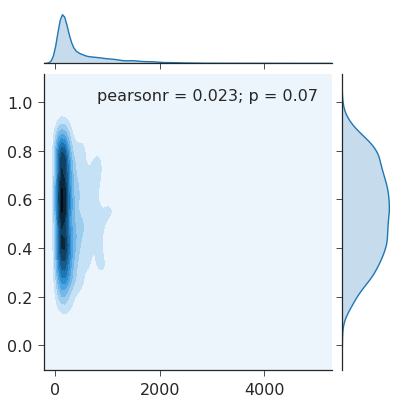

In [567]:
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
#ax = sns.kdeplot(ff/max(ff), ww/max(ww), shade=False,n_levels=10)
zz = df.sort_values('id').wins.map(float)
zz_L=df.sort_values('id').fails.map(float)
zz = array(zz)
ax=sns.jointplot(zz,diag(a['D_cosine']),  kind="kde")#,xlim=[1.5,3.5],ylim=[.4,3])
#xlabe
#ax.set(xlim=[0,.5],ylim=[0,.5])

#ax.set_axis_labels(xlabel='$log10(wins)$',ylabel='$log10(fails)$') 

In [568]:
from scipy.stats import spearmanr,pearsonr
scores = diag(a['D_cosine'])
spearmanr(zz_L ,scores)

SpearmanrResult(correlation=-0.07543714468885346, pvalue=4.677570319625186e-09)

In [584]:
zs = []
for networkName,networkFun in networks.items():
    print networkName
    curOutPath = os.path.join(outputDir,networkName+'.pkl')
    dists_out_path = curOutPath+'.dist'
    a = pickle.load(open(dists_out_path))
    for k in ['D_cosine','D_euclid']:
        D = a[k]
        D_sorted=D.argsort(axis=1)
        #N=float(len(D))
        N=len(D)
        D_true = array(range(N)).reshape(N,1)
        d=((D_sorted==D_true).sum(0)).astype(float)
        #plot(arange(0,1,1./N), cumsum(d)/sum(d))#,xlabel='index')#,ylabel=)
        # plot the recall at different points.    
        zz=cumsum(sum(D_sorted==D_true,0))
        zs.append((networkName,k,zz))    
if False:
    N = float(N)
    print 'recall @ 0,5,10,100:',100*zz[[0,4,9,99]]/N
    z=nonzero(D_sorted==D_true)[1]
    aa=hist(z[z<=inf],100,normed=True,cumulative=True,histtype='step',linewidth=2)
    xlabel('no images');
    ylabel('$p(hit)$');

resnet18
resnet50
vgg16
densenet201
densenet121
resnet152
densenet169
alexnet


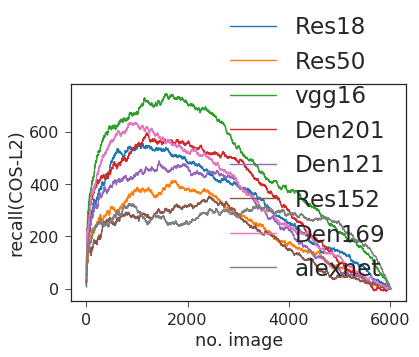

In [570]:
#%pylab inline
map_net_type = lambda x:x.replace('resnet','Res').replace('densenet','Den')
euclids = []
coss = []
types = []
for net_type,dist_type,recalls in zs:
    if dist_type=='D_cosine':
        coss.append(recalls)
        types.append(map_net_type(net_type))
    else:
        euclids.append(recalls)    
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('large') 
# large, medium, smaller, None, small, x-large, xx-small, larger, x-small, xx-large
#plot( (array(coss)-array(euclids)).T);legend(types,ncol=1,fancybox=True,shadow=True,prop=fontP)
plot( (array(coss)-array(euclids)).T);legend(types,ncol=1,fancybox=True,shadow=True,prop=fontP)
xlabel('no. image')
ylabel('recall(COS-L2)')
if toSaveFigures:
  savefig(os.path.join(saveFigsBaseDir,'recall_COS_vs_L2.pdf'),bbox_inches='tight')


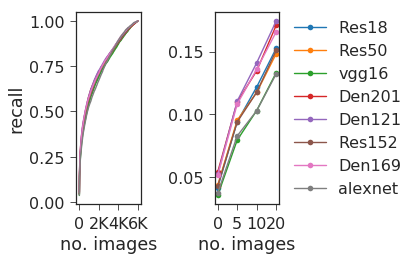

In [572]:
sns.set_context('paper',font_scale=2)
sns.set_style('ticks')
nb = 0
#z1 = [q[2] for q in zs[2*nb:2*nb+2]]
#z1 = [q[2] for q in zs[::2]]
zs1 = [q for q in zs if q[1]=='D_cosine']
z1 = [q[2] for q in zs1]# if q[1]=='D_cosine']
mm=1
nn=2
subplot(mm,nn,1);plot(array(z1).T/float(N),'-'); 
xs = range(0,N,2000)
labels=map(lambda x: str(x/1000)+'K' if x > 0 else '0',xs)
xlabel('no. images');xticks(xs,labels,rotation=0)
ylabel('recall')
xs = [0,5,10,20]
subplot(mm,nn,2);plot(array(z1).T[xs,:]/float(N),'-o');xticks(range(len(xs)),[str(x) for x in xs])
xlabel('no. images');
#legend_values=[map_net_type(q[0])+' / '+ d1[q[1]] for q in zs1]
legend_values=[map_net_type(q[0]) for q in zs1]
d1 = {'D_cosine':'COS','D_euclid':'L2'}
gca().legend(legend_values,loc='center left',bbox_to_anchor=(1, .5),ncol=1)#, fancybox=True, shadow=True)
plt.tight_layout();
if toSaveFigures:
  savefig(os.path.join(saveFigsBaseDir,'recall_and_zoom_without_duplicates.pdf'),bbox_inches='tight')
#legend(legend_values,loc='right')


In [695]:
#all_dups = is_dup_right | is_dup_left | face_dups | (cross_dists <= .15)# | (cross_face_dists <= .4)
right_generic_thresh=.1
is_dup_right = dists_right <=right_generic_thresh
is_dup_left = dists_left <=right_generic_thresh
all_dups = is_dup_right | is_dup_left | face_dups | (cross_dists <= .15) | (cross_face_dists <= .4)
zs = []
sel = logical_not(all_dups)
print('number of images afer de-duplication:',sum(sel))
#sel = logical_and(sel,~sel_face)
for networkName,networkFun in networks.items():
    print networkName
    #if networkName!='densenet121':
    #    continue
    curOutPath = os.path.join(outputDir,networkName+'.pkl')
    dists_out_path = curOutPath+'.dist'
    a = pickle.load(open(dists_out_path))
    G = array(a['G'])
    k = 'D_cosine'    
    for k in ['D_cosine']:
        D = a[k]
        D = a[k]
        D = D[sel]
        D = D[:,sel]        
        D_sorted=D.argsort(axis=1)
        #N=float(len(D))
        N=len(D)
        D_true = array(range(N)).reshape(N,1)
        d=((D_sorted==D_true).sum(0)).astype(float)
        #plot(arange(0,1,1./N), cumsum(d)/sum(d))#,xlabel='index')#,ylabel=)
        # plot the recall at different points.    
        zz=cumsum(sum(D_sorted==D_true,0))
        zs.append((networkName,k,zz))    
    #break
if False:
    N = float(N)
    print 'recall @ 0,5,10,100:',100*zz[[0,4,9,99]]/N
    z=nonzero(D_sorted==D_true)[1]
    aa=hist(z[z<=inf],100,normed=True,cumulative=True,histtype='step',linewidth=2)
    xlabel('no images');
    ylabel('$p(hit)$');

('number of images afer de-duplication:', 1828)
resnet18
resnet50
vgg16
densenet201
densenet121
resnet152
densenet169
alexnet


In [696]:
def plotDistanceFigures(zs):
    import seaborn as sns
    map_net_type = lambda x:x.replace('resnet','Res').replace('densenet','Den')
    sns.set_context('paper',font_scale=2)
    sns.set_style('ticks')
    nb = 0
    #z1 = [q[2] for q in zs[2*nb:2*nb+2]]
    #z1 = [q[2] for q in zs[::2]]
    zs1 = [q for q in zs if q[1]=='D_cosine']
    z1 = [q[2] for q in zs1]# if q[1]=='D_cosine']
    mm=1
    nn=2
    subplot(mm,nn,1);plot(array(z1).T/float(N),'-'); 
    Q=700
    xs = range(0,N,Q)
    labels=map(lambda x: str(x) if x > 0 else '0',xs)
    xlabel('no. images');xticks(xs,labels,rotation=0)
    ylabel('recall')
    xs = [0,4,9,19]
    subplot(mm,nn,2);plot(array(z1).T[xs,:]/float(N),'-o');xticks(range(len(xs)),[str(x+1) for x in xs])
    xlabel('no. images');
    #legend_values=[map_net_type(q[0])+' / '+ d1[q[1]] for q in zs1]
    legend_values=[map_net_type(q[0]) for q in zs1]
    d1 = {'D_cosine':'COS','D_euclid':'L2'}
    gca().legend(legend_values,loc='center left',bbox_to_anchor=(1, .5),ncol=1)#, fancybox=True, shadow=True)
    plt.tight_layout();
    return z1,xs

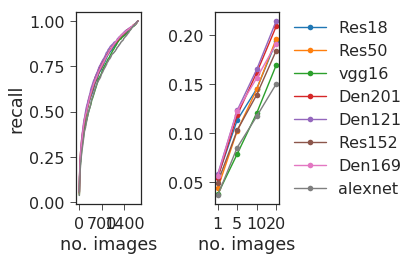

In [697]:
z1,xs=plotDistanceFigures(zs)
if toSaveFigures:
  savefig(os.path.join(saveFigsBaseDir,'recall_and_zoom_without_duplicates.pdf'),bbox_inches='tight')
##legend(legend_values,loc='right')

# Produce Table 1 from paper

In [698]:
TT=(array(z1).T[xs+[49,99],:]/float(N))
TT = TT.T
import pandas as pd
df=pd.DataFrame(around(100*TT,2),index=legend_values,columns=['R@'+str(p+1) for p in (xs+[49,99])])
df=df.sort_values('R@1')
df

,R@1,R@5,R@10,R@20,R@50,R@100
alexnet,3.67,8.53,11.71,14.99,22.59,30.63
vgg16,3.77,7.88,12.04,16.90,24.02,32.39
Res50,4.38,10.23,14.44,19.58,28.77,36.71
Res152,4.98,10.28,13.89,18.38,26.20,35.61
Den201,5.47,11.82,16.14,20.84,30.47,38.18
Res18,5.53,11.32,14.50,19.31,28.06,35.61
Den169,5.69,12.25,15.59,19.09,28.67,37.53
Den121,5.80,12.31,16.47,21.39,29.92,38.89


In [699]:
if False:
  with open("my_table1.tex", "w") as f:
      f.write('\\documentclass{article}\n\
      \n\\usepackage{booktabs}\n\
          \\begin{document}\n')
      f.write(df.to_latex())
      f.write('\\end{document}')

In [700]:
# involve face distance as well.
face_generic_dists_path = os.path.join(outputDir,'faces_generic_dists.pkl') 
aa = pickle.load(open(face_generic_dists_path))
# calculate the stuff for the faces.
# exclude faces where images did not include any faces.
selection_ = diag(aa < 100)
aa1=aa[selection_]
D_true=find(selection_)
NN = len(D_true)
D_true = D_true.reshape(NN,1)
D_sorted = aa1.argsort(1)
zz=cumsum(sum(D_sorted==D_true,0))
print 'percentage @1,5,10,20'
100*zz[[1,5,10,20]]/float(NN) # array([ 2.95373665,  5.72953737,  7.61565836, 11.31672598])
# same for specific face features.

/home/amir/anaconda2/envs/universe/lib/python2.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.


percentage @1,5,10,20


array([ 3.06049822,  5.65836299,  8.14946619, 11.49466192])

In [703]:
# And again, this time without faces either!
# Let's do this again, this time remove all the near duplicates - with a threshold of .15
zs = []
#sel = logical_and(~sel_face,sel_dup)
all_dups = is_dup_right | is_dup_left | face_dups | (cross_dists <= .15) | (cross_face_dists <= .4)
sel_no_faces = (~is_dup_right & ~is_dup_left &  ~sel_face)
#sel = ~all_dups | sel_no_faces
sel = sel_no_faces

In [704]:
sum(sel)

1622

In [705]:
print('number of selected images excluding faces and duplicates :',sum(sel_no_faces))
for networkName,networkFun in networks.items():
    print networkName
    curOutPath = os.path.join(outputDir,networkName+'.pkl')
    dists_out_path = curOutPath+'.dist'
    a = pickle.load(open(dists_out_path))
    G = array(a['G'])
    k = 'D_cosine'    
    for k in ['D_cosine']:
        D = a[k]
        D = D[sel]
        D = D[:,sel]
        D_sorted=D.argsort(axis=1)
        #N=float(len(D))
        N=len(D)
        D_true = array(range(N)).reshape(N,1)
        d=((D_sorted==D_true).sum(0)).astype(float)
        #plot(arange(0,1,1./N), cumsum(d)/sum(d))#,xlabel='index')#,ylabel=)
        # plot the recall at different points.    
        zz=cumsum(sum(D_sorted==D_true,0))
        zs.append((networkName,k,zz))    
if False:
    N = float(N)
    print 'recall @ 0,5,10,100:',100*zz[[0,4,9,99]]/N
    z=nonzero(D_sorted==D_true)[1]
    aa=hist(z[z<=inf],100,normed=True,cumulative=True,histtype='step',linewidth=2)
    xlabel('no images');
    ylabel('$p(hit)$');

('number of selected images excluding faces and duplicates :', 1622)
resnet18
resnet50
vgg16
densenet201
densenet121
resnet152
densenet169
alexnet


no faces: sel_obj = (~is_dup_right & ~is_dup_left &  ~sel_face) 
no dups: sel_d = ~is_dup_right &~ is_dup_left &~ (cross_dists <= .15)  &~ face_dups &~ (cross_face_dists <= .4) 

query_data
⮡no_faces
   ⮡random   
    ⮡human_query_paths  
    ⮡human_query_targets
    
    ⮡all_sels
    ⮡all_sels_f
  ⮡sort_D
    ⮡human_query_paths 
    ⮡human_query_targets
    ⮡all_sels
    ⮡all_sels_f
⮡no_dups
    ⮡random
      ⮡...
    ⮡sort_D
      ⮡...
    ⮡sort_F
      ⮡...
    ⮡sort_F_generic
      ⮡...      